# Model Development - Ryanair Customer Query Classification 
## **Objective**: Build and compare multiple machine learning models for customer query classification. 
## **Model Hierarchy Strategy:**
### 1. **Baseline**: TF-IDF + Logistic Regression (Fast & Simple)
### 2. **Advanced**: TF-IDF + SVM (More Powerful)
### 3. **Traditional ML**: Random Forest + Naive Bayes (Robust Alternatives)
### 4. **Gradient Boosting**: XGBoost + LightGBM + CatBoost (State-of-the-art)
### 5. **Ensemble**: Voting Classifier (Best Performance)

In [1]:
# Import  libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
import warnings
import time
from datetime import datetime
warnings.filterwarnings('ignore')

# Scikit-learn imports
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, 
    precision_recall_fscore_support, roc_auc_score
)
from sklearn.model_selection import cross_val_score, GridSearchCV
import joblib

print("All libraries imported successfully!")

All libraries imported successfully!


In [2]:
# Load processed data
print("Loading Processed Data...")
# Load training splits
train_split = pd.read_csv('../data/processed/train_split.csv')
val_split = pd.read_csv('../data/processed/val_split.csv')
test_processed = pd.read_csv('../data/processed/test_processed.csv')

# Load label encoder
with open('../data/processed/label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

# Load preprocessing info
with open('../data/processed/preprocessing_info.json', 'r') as f:
    preprocessing_info = json.load(f)

print(f"Data loaded successfully!")
print(f"   Training: {len(train_split):,} samples")
print(f"   Validation: {len(val_split):,} samples") 
print(f"   Test: {len(test_processed):,} samples")
print(f"   Classes: {preprocessing_info['n_classes']}")

# Prepare data
X_train = train_split['query_original'].fillna("")
y_train = train_split['label_encoded']
X_val = val_split['query_original'].fillna("")
y_val = val_split['label_encoded']
X_test = test_processed['query_lemmatized'].fillna("")  # For final predictions

print(f"\nData shapes:")
print(f"   X_train: {X_train.shape}")
print(f"   y_train: {y_train.shape}")
print(f"   X_val: {X_val.shape}")
print(f"   y_val: {y_val.shape}")

Loading Processed Data...
Data loaded successfully!
   Training: 16,000 samples
   Validation: 4,000 samples
   Test: 5,976 samples
   Classes: 30

Data shapes:
   X_train: (16000,)
   y_train: (16000,)
   X_val: (4000,)
   y_val: (4000,)


## 1. Baseline Model: TF-IDF + Logistic Regression

In [3]:
class ModelTracker:
    """Track model performance and artifacts."""
    
    def __init__(self):
        self.models = {}
        self.results = {}
        self.training_times = {}
        
    def add_model(self, name, model, X_train, y_train, X_val, y_val, vectorizer=None):
        """Train and evaluate a model."""
        print(f"\nTraining {name}...")
        start_time = time.time()
        
        # Train model
        if vectorizer:
            # For traditional ML models with vectorization
            X_train_vec = vectorizer.fit_transform(X_train)
            X_val_vec = vectorizer.transform(X_val)
            model.fit(X_train_vec, y_train)
            y_pred = model.predict(X_val_vec)
            y_pred_proba = model.predict_proba(X_val_vec) if hasattr(model, 'predict_proba') else None
        else:
            # For models that handle raw text
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            y_pred_proba = model.predict_proba(X_val) if hasattr(model, 'predict_proba') else None
        
        # Calculate metrics
        training_time = time.time() - start_time
        accuracy = accuracy_score(y_val, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_pred, average='weighted')
        
        # Store results
        self.models[name] = {
            'model': model,
            'vectorizer': vectorizer,
            'predictions': y_pred,
            'probabilities': y_pred_proba
        }
        
        self.results[name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'training_time': training_time
        }
        
        self.training_times[name] = training_time
        
        print(f"   {name} completed!")
        print(f"   Accuracy: {accuracy:.4f}")
        print(f"   F1-Score: {f1:.4f}")
        print(f"   Training Time: {training_time:.2f}s")
        
        return self.results[name]
    
    def get_results_df(self):
        """Get results as DataFrame."""
        return pd.DataFrame(self.results).T

# Initialize model tracker
tracker = ModelTracker()

In [4]:
# 1. BASELINE: TF-IDF + Logistic Regression
print("1. BASELINE MODEL: TF-IDF + Logistic Regression")
print("=" * 60)

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),  # Unigrams and bigrams
    min_df=2,            # Ignore terms in less than 2 documents
    max_df=0.95,         # Ignore terms in more than 95% of documents
    stop_words='english'
)

# Logistic Regression
lr_model = LogisticRegression(
    random_state=42,
    max_iter=1000,
    class_weight='balanced'  # Handle class imbalance
)

# Train and evaluate
baseline_results = tracker.add_model(
    'Baseline_LR', lr_model, X_train, y_train, X_val, y_val, tfidf_vectorizer
)

1. BASELINE MODEL: TF-IDF + Logistic Regression

🔄 Training Baseline_LR...
✅ Baseline_LR completed!
   Accuracy: 0.9845
   F1-Score: 0.9845
   Training Time: 1.55s


In [5]:
# 2. ADVANCED: TF-IDF + SVM
print("\n2. ADVANCED MODEL: TF-IDF + SVM")
print("=" * 50)

# SVM with optimized parameters
svm_model = SVC(
    kernel='rbf',
    random_state=42,
    class_weight='balanced',
    probability=True  # Enable probability predictions
)

# Use same TF-IDF vectorizer but create new instance for fair comparison
svm_vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95,
    stop_words='english'
)

# Train and evaluate
svm_results = tracker.add_model(
    'Advanced_SVM', svm_model, X_train, y_train, X_val, y_val, svm_vectorizer
)


2. ADVANCED MODEL: TF-IDF + SVM

🔄 Training Advanced_SVM...
✅ Advanced_SVM completed!
   Accuracy: 0.9872
   F1-Score: 0.9872
   Training Time: 67.56s


In [6]:
# 3. TRADITIONAL ML ALTERNATIVES
print("\n3. ADDITIONAL TRADITIONAL MODELS")
print("=" * 45)

# Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

rf_vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95,
    stop_words='english'
)

rf_results = tracker.add_model(
    'Random_Forest', rf_model, X_train, y_train, X_val, y_val, rf_vectorizer
)

# Naive Bayes
nb_model = MultinomialNB(alpha=1.0)
nb_vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95,
    stop_words='english'
)

nb_results = tracker.add_model(
    'Naive_Bayes', nb_model, X_train, y_train, X_val, y_val, nb_vectorizer
)


3. ADDITIONAL TRADITIONAL MODELS

🔄 Training Random_Forest...
✅ Random_Forest completed!
   Accuracy: 0.9830
   F1-Score: 0.9830
   Training Time: 3.02s

🔄 Training Naive_Bayes...
✅ Naive_Bayes completed!
   Accuracy: 0.9798
   F1-Score: 0.9797
   Training Time: 0.25s


In [7]:
# 4. GRADIENT BOOSTING MODELS
print("\n4. GRADIENT BOOSTING MODELS")
print("=" * 45)

# XGBoost
try:
    import xgboost as xgb
    
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1,
        eval_metric='mlogloss'  # Multi-class log loss
    )
    
    xgb_vectorizer = TfidfVectorizer(
        max_features=10000,
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.95,
        stop_words='english'
    )
    
    xgb_results = tracker.add_model(
        'XGBoost', xgb_model, X_train, y_train, X_val, y_val, xgb_vectorizer
    )
    
except ImportError:
    print("XGBoost not available. Install with: pip install xgboost")

# LightGBM
try:
    import lightgbm as lgb
    
    lgb_model = lgb.LGBMClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1,
        verbose=-1  # Suppress warnings
    )
    
    lgb_vectorizer = TfidfVectorizer(
        max_features=10000,
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.95,
        stop_words='english'
    )
    
    lgb_results = tracker.add_model(
        'LightGBM', lgb_model, X_train, y_train, X_val, y_val, lgb_vectorizer
    )
    
except ImportError:
    print("LightGBM not available. Install with: pip install lightgbm")

# CatBoost
try:
    from catboost import CatBoostClassifier
    
    catboost_model = CatBoostClassifier(
        iterations=100,           # n_estimators equivalent
        depth=6,                  # max_depth
        learning_rate=0.1,
        random_state=42,
        verbose=False,            # Silent training
        thread_count=-1           # Use all cores
    )
    
    catboost_vectorizer = TfidfVectorizer(
        max_features=10000,
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.95,
        stop_words='english'
    )
    
    catboost_results = tracker.add_model(
        'CatBoost', catboost_model, X_train, y_train, X_val, y_val, catboost_vectorizer
    )
    
except ImportError:
    print("CatBoost not available. Install with: pip install catboost")


4. GRADIENT BOOSTING MODELS

🔄 Training XGBoost...
✅ XGBoost completed!
   Accuracy: 0.9812
   F1-Score: 0.9813
   Training Time: 40.64s

🔄 Training LightGBM...
✅ LightGBM completed!
   Accuracy: 0.9830
   F1-Score: 0.9830
   Training Time: 6.61s

🔄 Training CatBoost...
✅ CatBoost completed!
   Accuracy: 0.9597
   F1-Score: 0.9603
   Training Time: 156.98s


## 5. Ensemble Model: Voting Classifier

In [8]:
print("\n5. ENSEMBLE MODEL: Voting Classifier")
print("=" * 50)

# Prepare models for ensemble (using best performers)
ensemble_models = []

# Add Logistic Regression (baseline)
lr_ensemble = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
ensemble_models.append(('lr', lr_ensemble))
print("Logistic Regression added to ensemble")

# Add SVM (advanced)
svm_ensemble = SVC(kernel='rbf', random_state=42, class_weight='balanced', probability=True)
ensemble_models.append(('svm', svm_ensemble))
print("SVM added to ensemble")

# Add Random Forest (robust)
rf_ensemble = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)
ensemble_models.append(('rf', rf_ensemble))
print("Random Forest added to ensemble")

# Add XGBoost if available
try:
    import xgboost as xgb
    xgb_ensemble = xgb.XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1, eval_metric='mlogloss')
    ensemble_models.append(('xgb', xgb_ensemble))
    print("XGBoost added to ensemble")
except ImportError:
    print("XGBoost not available for ensemble")

# Add LightGBM if available
try:
    import lightgbm as lgb
    lgb_ensemble = lgb.LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1, verbose=-1)
    ensemble_models.append(('lgb', lgb_ensemble))
    print("LightGBM added to ensemble")
except ImportError:
    print("LightGBM not available for ensemble")

# Add CatBoost if available
try:
    from catboost import CatBoostClassifier
    catboost_ensemble = CatBoostClassifier(iterations=100, random_state=42, verbose=False, thread_count=-1)
    ensemble_models.append(('catboost', catboost_ensemble))
    print("CatBoost added to ensemble")
except ImportError:
    print("CatBoost not available for ensemble")

print(f"\nEnsemble will use {len(ensemble_models)} models")

# Create Voting Classifier
voting_classifier = VotingClassifier(
    estimators=ensemble_models,
    voting='soft'  # Use probability voting
)

# Create ensemble vectorizer
ensemble_vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95,
    stop_words='english'
)

# Train and evaluate ensemble
ensemble_results = tracker.add_model(
    'Ensemble_Voting', voting_classifier, X_train, y_train, X_val, y_val, ensemble_vectorizer
)


5. ENSEMBLE MODEL: Voting Classifier
Logistic Regression added to ensemble
SVM added to ensemble
Random Forest added to ensemble
XGBoost added to ensemble
LightGBM added to ensemble
CatBoost added to ensemble

Ensemble will use 6 models

🔄 Training Ensemble_Voting...
✅ Ensemble_Voting completed!
   Accuracy: 0.9848
   F1-Score: 0.9847
   Training Time: 253.14s


## 6. Model Comparison & Analysis

In [13]:
print("\nMODEL COMPARISON RESULTS")
print("=" * 60)

# Get results DataFrame
results_df = tracker.get_results_df()
print(results_df.round(4))

# Find best model
best_model_name = results_df['f1_score'].idxmax()
best_f1 = results_df.loc[best_model_name, 'f1_score']

print(f"\nBEST MODEL: {best_model_name}")
print(f"   F1-Score: {best_f1:.4f}")
print(f"   Accuracy: {results_df.loc[best_model_name, 'accuracy']:.4f}")


MODEL COMPARISON RESULTS
                 accuracy  precision  recall  f1_score  training_time
Baseline_LR        0.9845     0.9846  0.9845    0.9845         1.5532
Advanced_SVM       0.9872     0.9874  0.9872    0.9872        67.5587
Random_Forest      0.9830     0.9832  0.9830    0.9830         3.0236
Naive_Bayes        0.9798     0.9801  0.9798    0.9797         0.2524
XGBoost            0.9812     0.9814  0.9812    0.9813        40.6373
LightGBM           0.9830     0.9832  0.9830    0.9830         6.6113
CatBoost           0.9598     0.9626  0.9598    0.9603       156.9752
Ensemble_Voting    0.9848     0.9849  0.9848    0.9847       253.1380

BEST MODEL: Advanced_SVM
   F1-Score: 0.9872
   Accuracy: 0.9872


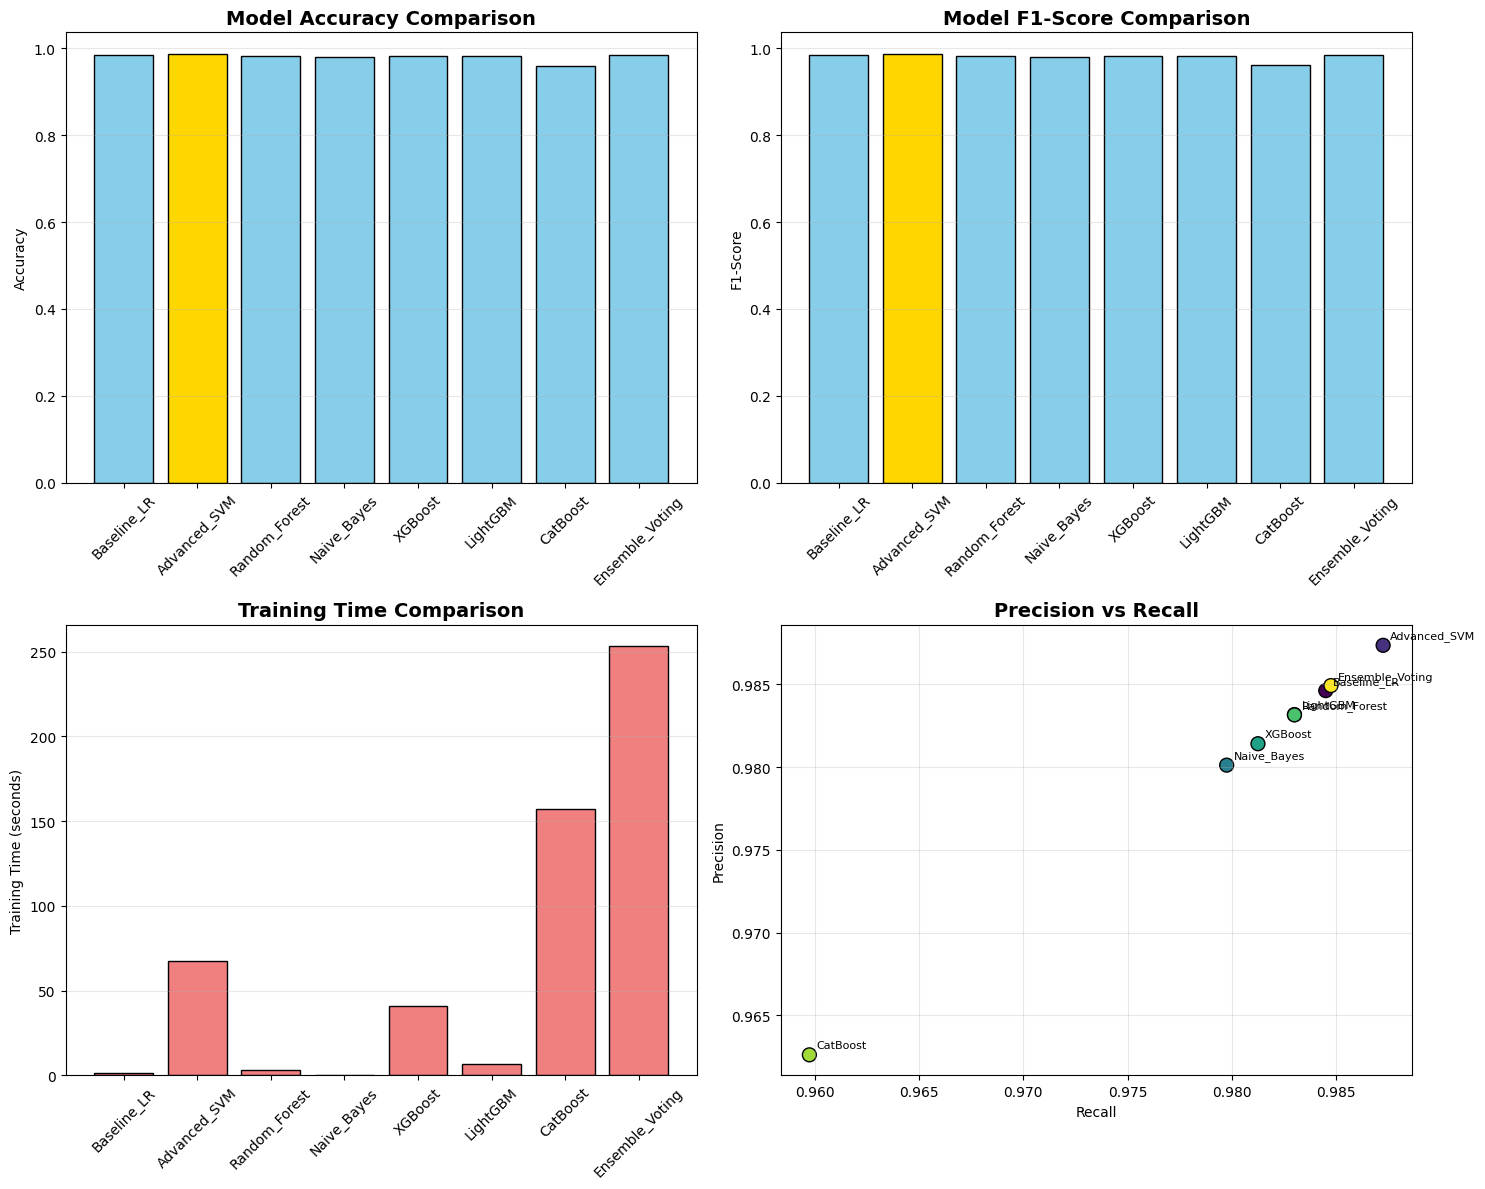

In [14]:
# Visualize model comparison
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. Accuracy Comparison
models = results_df.index
accuracies = results_df['accuracy']
colors = ['gold' if model == best_model_name else 'skyblue' for model in models]

ax1.bar(models, accuracies, color=colors, edgecolor='black')
ax1.set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.set_ylabel('Accuracy')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# 2. F1-Score Comparison
f1_scores = results_df['f1_score']
ax2.bar(models, f1_scores, color=colors, edgecolor='black')
ax2.set_title('Model F1-Score Comparison', fontsize=14, fontweight='bold')
ax2.set_ylabel('F1-Score')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)

# 3. Training Time Comparison
training_times = results_df['training_time']
ax3.bar(models, training_times, color='lightcoral', edgecolor='black')
ax3.set_title('Training Time Comparison', fontsize=14, fontweight='bold')
ax3.set_ylabel('Training Time (seconds)')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(axis='y', alpha=0.3)

# 4. Precision vs Recall
precisions = results_df['precision']
recalls = results_df['recall']
ax4.scatter(recalls, precisions, s=100, c=range(len(models)), cmap='viridis', edgecolor='black')
for i, model in enumerate(models):
    ax4.annotate(model, (recalls[i], precisions[i]), xytext=(5, 5), 
                textcoords='offset points', fontsize=8)
ax4.set_xlabel('Recall')
ax4.set_ylabel('Precision')
ax4.set_title('Precision vs Recall', fontsize=14, fontweight='bold')
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Detailed Error Analysis


DETAILED ERROR ANALYSIS

📋 Classification Report - Advanced_SVM:
                             precision    recall  f1-score   support

           Airport Services       0.99      0.98      0.98        99
           Baggage Policies       0.98      0.96      0.97       153
            Business Travel       1.00      1.00      1.00       102
          COVID-19 Policies       0.98      0.96      0.97       130
        Check-in Procedures       0.99      0.99      0.99       139
    Child and Infant Travel       1.00      0.99      1.00       116
    Complaints and Feedback       1.00      0.99      1.00       177
    Customer Account Issues       1.00      0.99      0.99       142
         Duty-Free Shopping       1.00      1.00      1.00        96
            Flight Bookings       0.98      0.96      0.97       146
             Flight Changes       0.99      0.98      0.98       157
              Flight Status       0.95      0.99      0.97       165
       Frequent Flyer Miles       0.

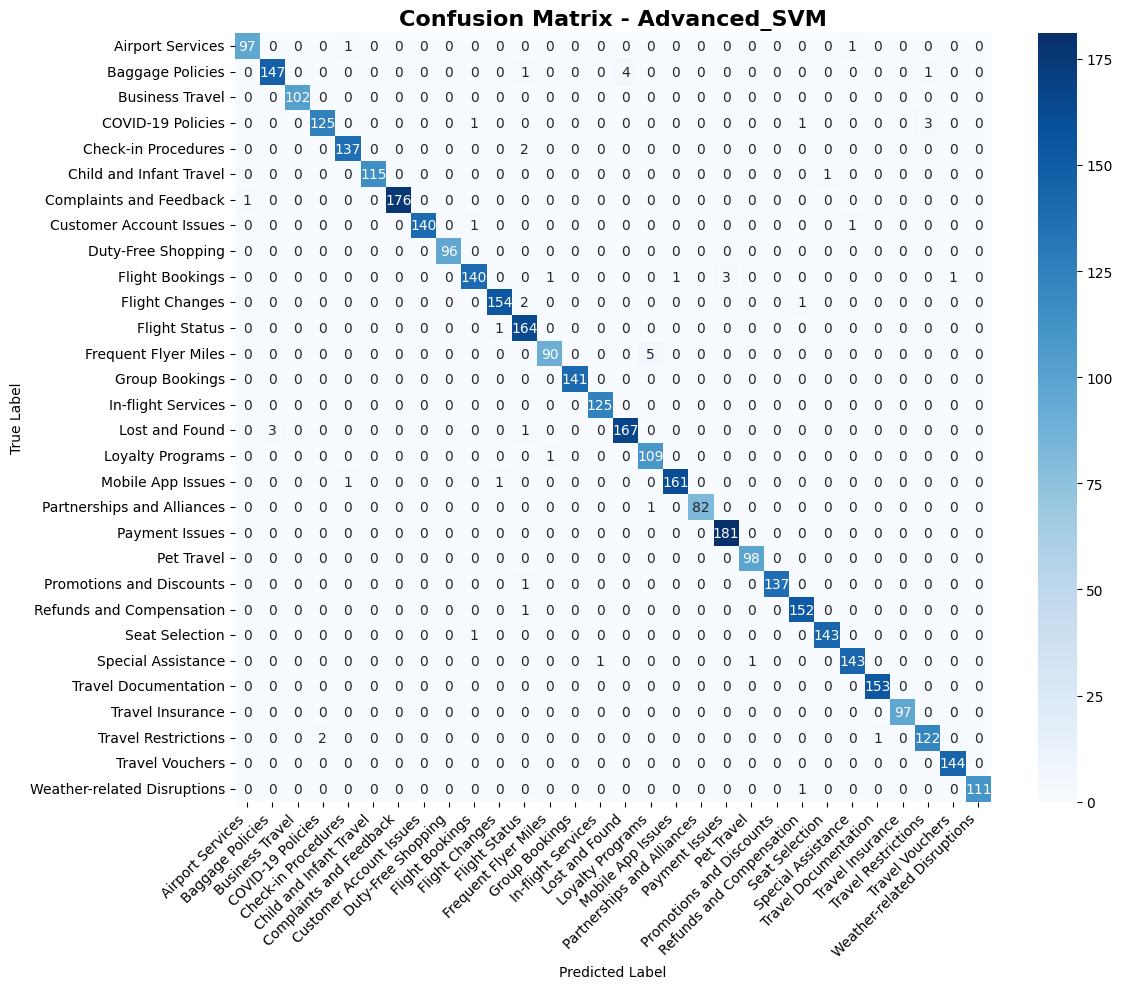

In [15]:
print("\nDETAILED ERROR ANALYSIS")
print("=" * 40)

# Use best model for detailed analysis
best_model_info = tracker.models[best_model_name]
best_predictions = best_model_info['predictions']

# Classification report
print(f"\n📋 Classification Report - {best_model_name}:")
class_names = label_encoder.classes_
print(classification_report(y_val, best_predictions, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_val, best_predictions)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('../reports/figures/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Save Models and Results

In [16]:
# %%
print("\nSAVING MODELS AND RESULTS")
print("=" * 40)

# Create models directory
import os
os.makedirs('../models', exist_ok=True)

# Save best model
best_model = tracker.models[best_model_name]['model']
best_vectorizer = tracker.models[best_model_name]['vectorizer']

joblib.dump(best_model, f'../models/best_model_{best_model_name}.pkl')
joblib.dump(best_vectorizer, f'../models/best_vectorizer_{best_model_name}.pkl')

# Save all results
results_df.to_csv('../reports/model_comparison_results.csv')

# Save model artifacts
model_artifacts = {
    'best_model': best_model_name,
    'best_f1_score': float(best_f1),
    'best_accuracy': float(results_df.loc[best_model_name, 'accuracy']),
    'all_results': results_df.to_dict(),
    'label_encoder_classes': label_encoder.classes_.tolist(),
    'training_date': datetime.now().isoformat()
}

with open('../models/model_artifacts.json', 'w') as f:
    json.dump(model_artifacts, f, indent=2)

print(f"Models saved successfully!")
print(f"Best model: {best_model_name}")
print(f"Saved to: ../models/")


SAVING MODELS AND RESULTS
Models saved successfully!
Best model: Advanced_SVM
Saved to: ../models/


## 9. Final Model Performance Summary

In [17]:
print("\nFINAL MODEL DEVELOPMENT SUMMARY")
print("=" * 60)
print(f"Models Trained: {len(results_df)}")
print(f"Best Model: {best_model_name}")
print(f"Best F1-Score: {best_f1:.4f}")
print(f"Best Accuracy: {results_df.loc[best_model_name, 'accuracy']:.4f}")

print(f"\nAll Model Performance:")
for model_name, row in results_df.iterrows():
    status = "Best Model" if model_name == best_model_name else "Other Models"
    print(f"   {status} {model_name}: F1={row['f1_score']:.4f}, Acc={row['accuracy']:.4f}")

print(f"\nNext Steps:")
print("   • Hyperparameter tuning for best model")
print("   • Cross-validation analysis")
print("   • Error analysis and model interpretation")
print("   • Production deployment preparation")

print(f"\nArtifacts Saved:")
print("   • ../models/best_model_[name].pkl")
print("   • ../models/best_vectorizer_[name].pkl") 
print("   • ../models/model_artifacts.json")
print("   • ../reports/model_comparison_results.csv")

print(f"\nModel Development Complete!")
print("Ready for hyperparameter tuning and final evaluation!")


FINAL MODEL DEVELOPMENT SUMMARY
Models Trained: 8
Best Model: Advanced_SVM
Best F1-Score: 0.9872
Best Accuracy: 0.9872

All Model Performance:
   Other Models Baseline_LR: F1=0.9845, Acc=0.9845
   Best Model Advanced_SVM: F1=0.9872, Acc=0.9872
   Other Models Random_Forest: F1=0.9830, Acc=0.9830
   Other Models Naive_Bayes: F1=0.9797, Acc=0.9798
   Other Models XGBoost: F1=0.9813, Acc=0.9812
   Other Models LightGBM: F1=0.9830, Acc=0.9830
   Other Models CatBoost: F1=0.9603, Acc=0.9597
   Other Models Ensemble_Voting: F1=0.9847, Acc=0.9848

Next Steps:
   • Hyperparameter tuning for best model
   • Cross-validation analysis
   • Error analysis and model interpretation
   • Production deployment preparation

Artifacts Saved:
   • ../models/best_model_[name].pkl
   • ../models/best_vectorizer_[name].pkl
   • ../models/model_artifacts.json
   • ../reports/model_comparison_results.csv

Model Development Complete!
Ready for hyperparameter tuning and final evaluation!
